### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import math

from sklearn.metrics import log_loss, make_scorer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import KFold, StratifiedKFold, StratifiedGroupKFold

from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings("ignore")

### Data Prep

In [2]:
# BASE_DIR = '/kaggle/input/icr-identify-age-related-conditions/'
BASE_DIR = '../data'
train = pd.read_csv(f'{BASE_DIR}/train.csv')
greeks = pd.read_csv(f'{BASE_DIR}/greeks.csv')
test = pd.read_csv(f'{BASE_DIR}/test.csv')
submission = pd.read_csv(f'{BASE_DIR}/sample_submission.csv')

# test_df[CFG.target_col] = -1
# all_df = pd.concat([train_df, test_df])

### 欠損値は中央値で埋める

<AxesSubplot:>

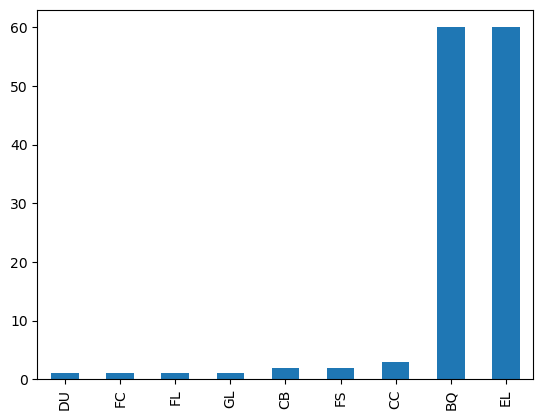

In [3]:
missing = train.isnull().sum()
missing = missing[missing>0]
missing.sort_values(inplace=True)
missing.plot.bar()

In [4]:
for idx in missing.index:
    train[idx] = train[idx].fillna(train[idx].mean())
    test[idx] = test[idx].fillna(test[idx].mean())

### 特徴量の数を確認

In [5]:
# 列名を取得
cols = train.columns
# 特徴量の列名のみ抽出
feat_cols = cols[1:]
# 数値データのみ抽出
num_cols = train.select_dtypes(include=['float64']).columns
# 列数をカウント
print("No of Columns: ", len(cols))

No of Columns:  58


### 評価指標の計算

In [6]:
# コンペティションの評価指標
def competition_log_loss(y_true, y_pred):
    N_0 = np.sum(1 - y_true)
    N_1 = np.sum(y_true)
    p_1 = np.clip(y_pred, 1e-15, 1 - 1e-15)
    p_0 = 1 - p_1
    log_loss_0 = -np.sum((1 - y_true) * np.log(p_0)) / N_0
    log_loss_1 = -np.sum(y_true * np.log(p_1)) / N_1
    return (log_loss_0 + log_loss_1)/2

# こっちはようわからん
def balanced_log_loss(y_true, y_pred):
    N_0 = np.sum(1 - y_true)
    N_1 = np.sum(y_true)
    p_1 = np.clip(y_pred, 1e-15, 1 - 1e-15)
    p_0 = 1 - p_1
    log_loss_0 = -np.sum((1 - y_true) * np.log(p_0))
    log_loss_1 = -np.sum(y_true * np.log(p_1))
    w_0 = 1 / N_0
    w_1 = 1 / N_1
    balanced_log_loss = 2*(w_0 * log_loss_0 + w_1 * log_loss_1) / (w_0 + w_1)
    return balanced_log_loss/(N_0+N_1)

# light-gbmの学習中に使用するための関数
def lgb_metric(y_true, y_pred):
    return 'balanced_log_loss', balanced_log_loss(y_true, y_pred), False

### スケーリング

In [7]:
# ラベルエンコーディング
train["EJ"] = train["EJ"].map({'A':0, 'B':1})
test["EJ"] = test["EJ"].map({'A':0, "B":1})

In [8]:
# インスタンス生成
scaler = StandardScaler()
# 訓練データ、テストデータのコピー
df, test_df = train.copy(), test.copy()
# ラベルエンコーディングを行なったので改めて数値データの特徴量を取得
new_num_cols = train.select_dtypes(include=['float64']).columns
# 訓練データを標準化
df[new_num_cols] = scaler.fit_transform(train[new_num_cols])
# テストデータを標準化
test_df[new_num_cols] = scaler.transform(test[new_num_cols])
# データを確認
df

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
0,000ff2bfdfe9,-0.572153,-0.170975,-0.261669,-0.237889,-0.189295,-1.900558,-0.083417,-0.173502,-0.038354,...,0.162487,-0.035806,-0.250869,-0.940094,-0.410260,-0.655511,-0.948991,0.531241,-0.815752,1
1,007255e47698,-0.709105,-1.097801,-0.261669,-0.028701,-0.189295,-0.750457,-0.083417,0.678919,-0.104787,...,-0.458281,-0.060566,0.113218,-1.145070,-0.410260,0.687893,-0.238862,-0.509218,1.304239,0
2,013f2bd269f5,-0.015212,-0.377169,-0.261669,-0.094845,-0.189295,0.465662,-0.083417,0.519453,-0.104787,...,0.198331,-0.051023,0.596934,1.637944,-0.299210,-0.051850,-0.351743,-0.424754,-0.808323,0
3,043ac50845d5,-0.480851,0.138196,0.012347,0.547477,-0.189295,-0.729610,-0.083417,0.112088,-0.104787,...,0.060027,-0.060566,-0.105234,-0.219883,-0.342195,-0.650833,0.858232,1.101332,-0.812311,0
4,044fb8a146ec,-0.206946,0.100517,-0.261669,-0.356885,-0.189295,-0.628845,-0.013229,-1.649292,1.445139,...,0.236971,0.896815,-0.230064,-0.432313,0.099920,-0.318309,1.409422,-0.395228,-0.818054,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612,fd3dafe738fd,-0.699975,-0.161828,0.040232,-0.422762,0.275215,-0.802577,0.040875,-0.464891,-0.080610,...,-0.458281,-0.045332,-0.271674,-1.177680,0.593022,-0.340465,-0.694915,0.513497,1.304239,0
613,fd895603f071,-0.088253,0.852755,-0.261669,0.108831,0.556117,0.170319,-0.082686,0.473063,-0.065661,...,0.417330,-0.045702,0.003992,1.519617,2.535523,-0.599582,-0.186764,2.048314,-0.813328,0
614,fd8ef6377f76,-0.106514,-0.453742,0.090140,0.235206,-0.011673,0.990330,-0.083417,1.113828,-0.104787,...,-0.458281,-0.060566,-0.271674,-0.076400,-0.019561,-0.424307,-0.540129,1.903449,1.304239,0
615,fe1942975e40,-0.243466,-0.973904,-0.261669,-0.219353,-0.189295,0.955584,-0.083417,-0.699741,-0.104787,...,0.333153,-0.054771,0.191237,0.387591,-0.410260,-0.657500,-0.646592,-0.370599,-0.809518,0


### クロスバリデーションの準備

In [9]:
# インスタンス生成
kf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
# fold列を作成
df['fold'] = -1
# 訓練データを分割
for fold, (train_idx, test_idx) in enumerate(kf.split(df, greeks['Alpha'])):
    df.loc[test_idx, 'fold'] = fold

In [10]:
# バリデーションスコアを格納
final_valid_predictions = {}
# テストデータの予測値を格納
final_test_predictions = []

scores = []
log_losses = []
balanced_log_losses = []
weights = []

In [11]:
for fold in range(5):
    train_df = df[df['fold'] != fold]
    valid_df = df[df['fold'] != fold]
    valid_ids = valid_df.Id.values.tolist()
    
    X_train, y_train = train_df.drop(['Id', 'Class', 'fold'], axis=1), train_df['Class']
    X_valid, y_valid = valid_df.drop(['Id', 'Class', 'fold'], axis=1), valid_df['Class']
    
    lgb = LGBMClassifier(boosting_type='goss', 
                         learning_rate=0.06733232950390658, 
                         n_estimators = 50000, 
                         early_stopping_round = 300, random_state=42,
                         subsample=0.6970532011679706,
                         colsample_bytree=0.6055755840633003,
                         class_weight='balanced',
                         metric='none', is_unbalance=True, max_depth=8)
    # 学習
    lgb.fit(X_train, y_train, eval_set=(X_valid, y_valid), verbose=1000, eval_metric=lgb_metric)
    
    # 検証データの予測
    y_pred = lgb.predict_proba(X_valid)
    
    # テストデータの予測
    preds_test = lgb.predict_proba(test_df.drop(['Id'], axis=1).values)
    
    # 検証データの予測結果を辞書に追加
    final_valid_predictions.update(dict(zip(valid_ids, y_pred)))
    # テストデータの予測結果をリストに追加
    final_test_predictions.append(preds_test)
    
    # loglossを計算（コンペで使用されてるやつ）
    logloss = log_loss(y_valid, y_pred)
    # balanced_loglossを計算（よくわからんやつ）
    balanced_logloss = balanced_log_loss(y_valid, y_pred[:, 1])
    # loglossをリストに追加
    log_losses.append(logloss)
    # balanced_log_lossをリストに追加
    balanced_log_losses.append(balanced_logloss)
    # weightsをリストに追加
    weights.append(1/balanced_logloss)

    # 進行状況をプリント
    print(f"Fold: {fold}, log loss: {logloss}, balanced los loss: {balanced_logloss}")
    print()
    print("Log Loss")
    print(log_losses)
    print(np.mean(log_losses), np.std(log_losses))
    print()
    print("Balanced Log Loss")
    print(balanced_log_losses)
    print(np.mean(balanced_log_losses), np.std(balanced_log_losses))
    print()
    print("Weights")
    print(weights)

[1000]	valid_0's balanced_log_loss: 1.87105e-06
[2000]	valid_0's balanced_log_loss: 1.29887e-06
[3000]	valid_0's balanced_log_loss: 1.25726e-06
Fold: 0, log loss: 3.128396546438618e-06, balanced los loss: 1.2615104015289935e-06

Log Loss
[3.128396546438618e-06]
3.128396546438618e-06 0.0

Balanced Log Loss
[1.2615104015289935e-06]
1.2615104015289935e-06 0.0

Weights
[792700.558622399]
[1000]	valid_0's balanced_log_loss: 1.99577e-06
[2000]	valid_0's balanced_log_loss: 1.32705e-06
Fold: 1, log loss: 3.2877968643957725e-06, balanced los loss: 1.3282807037220512e-06

Log Loss
[3.128396546438618e-06, 3.2877968643957725e-06]
3.208096705417195e-06 7.970015897857716e-08

Balanced Log Loss
[1.2615104015289935e-06, 1.3282807037220512e-06]
1.2948955526255224e-06 3.3385151096528824e-08

Weights
[792700.558622399, 752852.9151992067]
[1000]	valid_0's balanced_log_loss: 2.14312e-06
[2000]	valid_0's balanced_log_loss: 1.34355e-06
[3000]	valid_0's balanced_log_loss: 1.29775e-06
Fold: 2, log loss: 3.1471

In [12]:
# テストを格納する行列を作成
test_preds = np.zeros((test_df.shape[0], 2))
for i in range(5):
    # 重みとして損失関数の逆数をかける
    test_preds[:, 0] += weights[i] * final_test_predictions[i][:, 0]
    test_preds[:, 1] += weights[i] * final_test_predictions[i][:, 1]
# 最後に重みの合計で割る
test_preds /= sum(weights)
test_preds

array([[0.9505311, 0.0494689],
       [0.9505311, 0.0494689],
       [0.9505311, 0.0494689],
       [0.9505311, 0.0494689],
       [0.9505311, 0.0494689]])

In [14]:
test_dict = {}
test_dict.update(dict(zip(test.Id.values.tolist(), test_preds)))
submission = pd.DataFrame.from_dict(test_dict, orient="index").reset_index()
submission.columns = ['Id', 'class_0', 'class_1']

submission.to_csv(r"submission.csv", index=False)
submission

,Id,class_0,class_1
0,00eed32682bb,0.950531,0.049469
1,010ebe33f668,0.950531,0.049469
2,02fa521e1838,0.950531,0.049469
3,040e15f562a2,0.950531,0.049469
4,046e85c7cc7f,0.950531,0.049469
